In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvidia-smi

Sun Nov 26 11:08:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# EDA. Class selection

In [3]:
import json
from collections import Counter

with open('/kaggle/input/rtsd-dataset/train_anno.json') as file:
    train_anno = json.loads(file.read())
    
with open('/kaggle/input/rtsd-dataset/val_anno.json') as file:
    val_anno = json.loads(file.read())
    
class_names = {item['id']: item['name'] for item in train_anno['categories']}
samples_count_by_category = Counter([class_names[item['category_id']] for item in train_anno['annotations']])
invalid_categories_count = {cat_name:cat_count for cat_name, cat_count in samples_count_by_category.items() if cat_count < 25}

In [4]:
categories_mapping = {cls_name:cls_id for (cls_id,cls_name) in class_names.items()}
invalid_categories = {cat_name:categories_mapping[cat_name] for cat_name in invalid_categories_count.keys()}

In [5]:
from copy import deepcopy

def filter_invalid_categories(annotation, invalid_categories:dict[str, int]):
    annotation = deepcopy(annotation)
    valid_annotations = [ann for ann in annotation['annotations'] if ann['category_id'] not in invalid_categories.values()]
    valid_categories = [cat for cat in annotation['categories'] if cat['id'] not in invalid_categories.values()]
    valid_image_ids = set(ann['image_id'] for ann in valid_annotations)
    valid_images = [img for img in annotation['images'] if img['id'] in valid_image_ids]
    val_annotation = {
        'annotations': valid_annotations,
        'categories': valid_categories,
        'images': valid_images
    }
    return val_annotation

def remap_category_ids(annotation):
    # Create a mapping from original category IDs to new consecutive IDs
    category_id_mapping = {original_id: new_id for new_id, original_id in enumerate(set(cat['id'] for cat in annotation['categories']))}
    annotation = deepcopy(annotation)
    # Remap category IDs in annotations
    remapped_annotations = []
    for idx in range(len(annotation['annotations'])):
        remapped_ann = annotation['annotations'][idx]
        remapped_ann['category_id'] = category_id_mapping[remapped_ann['category_id']]
        remapped_annotations.append(remapped_ann)

    # Remap category IDs in categories
    remapped_categories = []
    for idx in range(len(annotation['categories'])):
        remapped_cat = annotation['categories'][idx]
        remapped_cat['id'] = category_id_mapping[remapped_cat['id']]
        remapped_categories.append(remapped_cat)

    remapped_annotation = {
        'annotations': remapped_annotations,
        'categories': remapped_categories,
        'images': annotation['images']
    }

    return remapped_annotation

In [6]:
with open('/kaggle/working/train_annotation.json', 'w') as f:
    json.dump(remap_category_ids(filter_invalid_categories(train_anno, invalid_categories)), f)

with open('/kaggle/working/val_annotation.json', 'w') as f:
    json.dump(remap_category_ids(filter_invalid_categories(val_anno, invalid_categories)), f)

In [7]:
with open('/kaggle/input/rtsd-dataset/labels.txt') as file:
    labels = file.read().splitlines()
    
labels = [label for label in labels if label not in invalid_categories.keys()]

with open('/kaggle/working/valid_labels.txt', 'w') as file:
     for label in labels:
        file.write(f"{label}\n")

In [8]:
import pandas as pd

df_for_plot = pd.DataFrame(
    {'class': samples_count_by_category.keys(),
    'count': samples_count_by_category.values()}
)

df_for_plot = df_for_plot.sort_values(by='count', ascending=True)

In [9]:
df_for_plot['flag'] = df_for_plot['class'].apply(lambda x: 1 if x not in list(invalid_categories.keys()) else 0)
df_for_plot[df_for_plot['flag'] == 1]['count'].sum()

95069

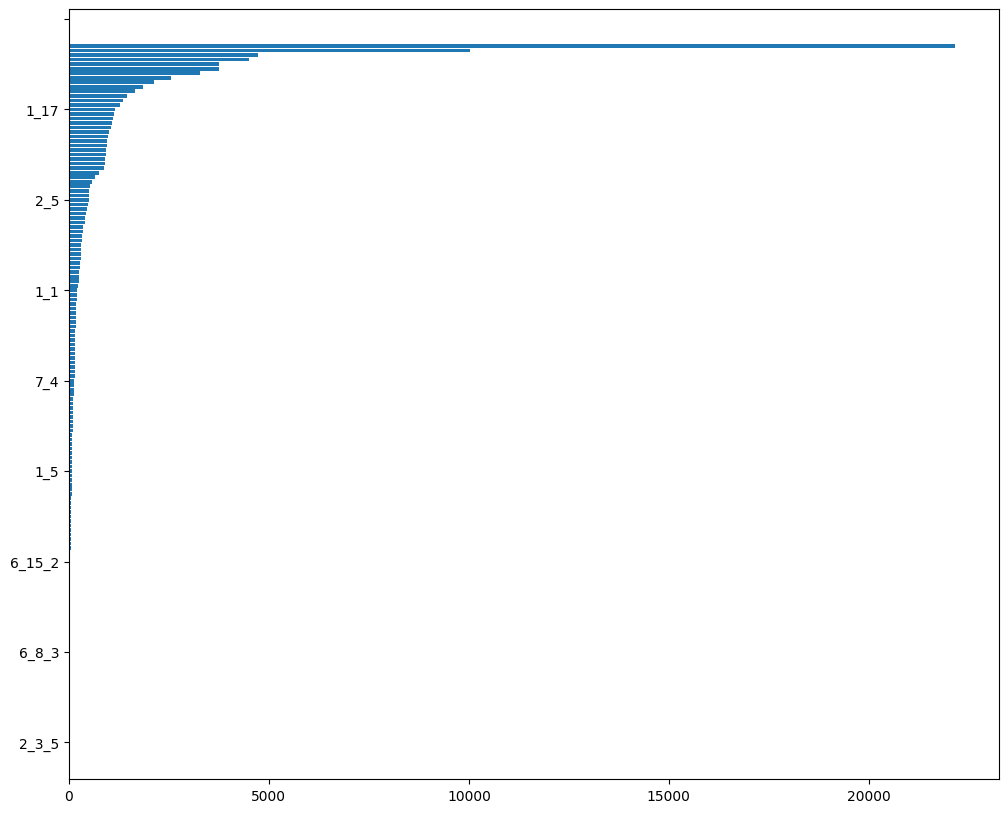

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12, 10))
plt.barh(df_for_plot['class'].tolist(), df_for_plot['count'].tolist())
plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))

# Prepare dataset to yolo-format

In [11]:
import json
import os
import shutil
import time

def coco_to_yolo(coco_folder, annotation_file, output_folder_images, output_folder_labels):
    start_time = time.time()
    
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    yolo_annotations = []
    cnt = 0
    
    for image_info in coco_data['images']:
        cnt += 1
        if cnt % 10000 == 0:
            print(f'cnt: {cnt}')
            print()
            
        image_id = image_info['id']
        file_name = image_info['file_name'].split('/')[1]
        width = image_info['width']
        height = image_info['height']

        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

        yolo_annotation = ""
        
        shutil.copy(os.path.join(coco_folder, 'rtsd-frames/rtsd-frames', file_name), output_folder_images)

        for ann in annotations:
            category_id = ann['category_id']
            bbox = ann['bbox']

            # Convert COCO bounding box format [x, y, width, height] to YOLO format [x_center, y_center, width, height]
            x_center = bbox[0] + bbox[2] / 2
            y_center = bbox[1] + bbox[3] / 2

            x_center /= width
            y_center /= height
            bbox_width = bbox[2] / width
            bbox_height = bbox[3] / height

            yolo_annotation += f"{category_id} {x_center} {y_center} {bbox_width} {bbox_height}\n"
            
        if yolo_annotation:
            with open(os.path.join(output_folder_labels, file_name.replace('jpg', 'txt')), 'w') as yolo_file:
                yolo_file.write(yolo_annotation)
    print(f'final count: {cnt}')      
    print(f'elapsed time : {time.time() - start_time} sec')

In [12]:
%mkdir /kaggle/working/data
%mkdir /kaggle/working/data/images
%mkdir /kaggle/working/data/labels
%mkdir /kaggle/working/data/images/train
%mkdir /kaggle/working/data/images/test
%mkdir /kaggle/working/data/labels/train
%mkdir /kaggle/working/data/labels/test

In [13]:
coco_to_yolo(
    '/kaggle/input/rtsd-dataset', 
    '/kaggle/working/train_annotation.json', 
    '/kaggle/working/data/images/train', 
    '/kaggle/working/data/labels/train'
)

cnt: 10000

cnt: 20000

cnt: 30000

cnt: 40000

cnt: 50000

final count: 54099
elapsed time : 940.0896902084351 sec


In [14]:
coco_to_yolo(
    '/kaggle/input/rtsd-dataset', 
    '/kaggle/working/val_annotation.json', 
    '/kaggle/working/data/images/test', 
    '/kaggle/working/data/labels/test'
)

final count: 4993
elapsed time : 46.37660884857178 sec


In [15]:
with open('/kaggle/working/valid_labels.txt') as file:
    labels = file.read().splitlines()

In [16]:
with open('/kaggle/working/data/traffic_signs.yaml', 'w') as yaml_file:
        yaml_file.write("train: /kaggle/working/data/images/train\n")
        yaml_file.write("val: /kaggle/working/data/images/test\n")
        yaml_file.write(f"nc: {len(labels)}\n")
        yaml_file.write(f"names: {labels}")

# Train

In [17]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.70 MiB | 29.76 MiB/s, done.
Resolving deltas: 100% (11034/11034), done.


In [18]:
%cd yolov5

/kaggle/working/yolov5


In [19]:
!pip install -r requirements.txt

  Obtaining dependency information for ultralytics>=8.0.147 from https://files.pythonhosted.org/packages/35/6b/26ef27d9fac7448d035028b730f4b4f84a382c40a806cda26e077122d6d4/ultralytics-8.0.218-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.8/645.8 kB 17.6 MB/s eta 0:00:0000:01


In [20]:
!python train.py --img 640 --batch -1 --epochs 15 --data /kaggle/working/data/traffic_signs.yaml --weights yolov5s.pt --device 0

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data/traffic_signs.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with h

In [21]:
!python detect.py --source /kaggle/working/data/images/test --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt --save-txt --save-conf --name "yolov5s_signs_test" --imgsz 640 --conf-thres 0.25

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/working/data/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5s_signs_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.9s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 157 layers, 7325674 parameters, 0 gradients, 16.8 GFLOPs
image 1/4993 /kaggle/

# Inference

/opt/conda/lib/python3.10/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.8s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2023-11-26 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 157 layers, 7325674 parameters, 0 gradients, 16.8 GFLOPs
Adding AutoShape... 


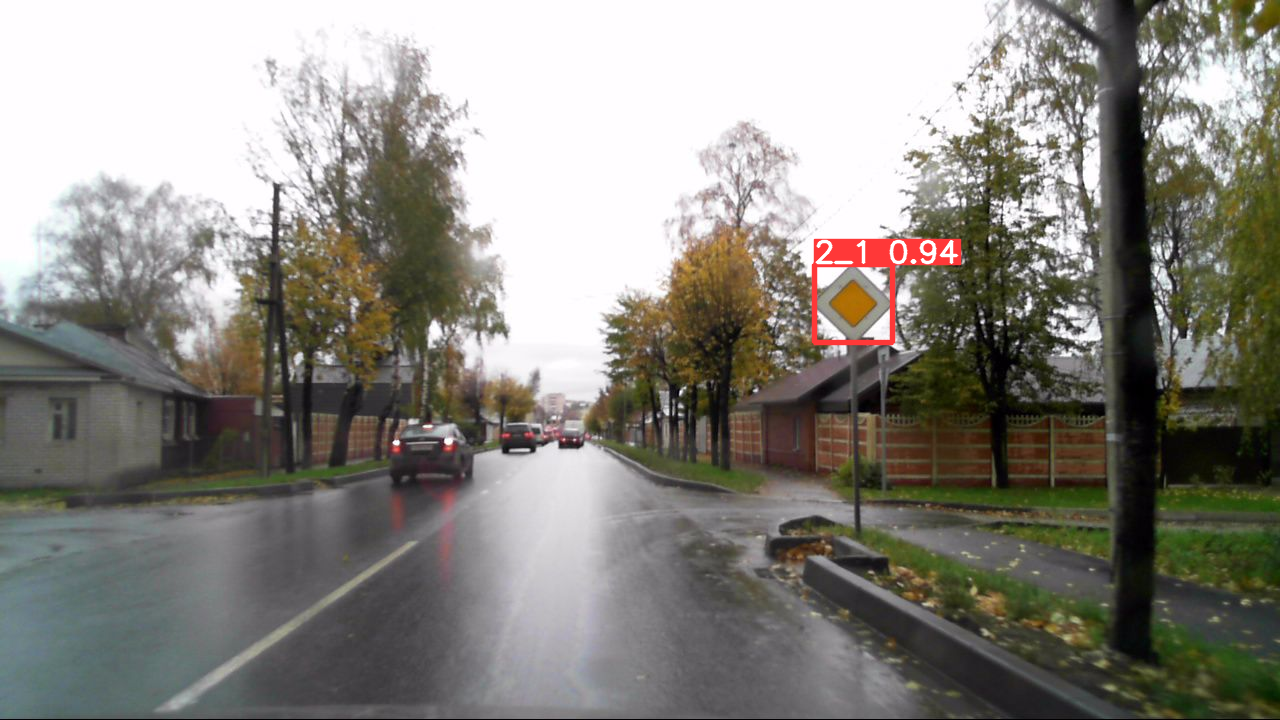

In [22]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

model = torch.hub.load(
    'ultralytics/yolov5',
    'custom',
    path='/kaggle/working/yolov5/runs/train/exp/weights/best.pt'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

img = '/kaggle/working/data/images/test/autosave10_10_2012_12_51_22_2.jpg'  
results = model(img)
results.show()

In [23]:
results

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 720x1280 1 2_1
Speed: 11.8ms pre-process, 46.7ms inference, 1.9ms NMS per image at shape (1, 3, 384, 640)

# Metrics

## Yolo logs

In [36]:
import matplotlib.pyplot as plt


metrics = pd.read_csv('/kaggle/working/yolov5/runs/train/exp/results.csv')

plt.plot(
    metrics['               epoch'],
    metrics['   metrics/precision'],
    label='precision'
)
plt.plot(
    metrics['               epoch'],
    metrics['      metrics/recall'],
    label='recall'
)
plt.grid()
plt.title('Precision/Recall')
plt.legend()

In [42]:
metrics[['               epoch', '      metrics/recall', '   metrics/precision', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']]

,epoch,metrics/recall,metrics/precision,metrics/mAP_0.5,metrics/mAP_0.5:0.95
0,0,0.010675,0.99527,0.017830,0.009922
1,1,0.059434,0.92544,0.068617,0.042476
2,2,0.127940,0.83002,0.118400,0.070200
3,3,0.181860,0.79193,0.181480,0.115400
4,4,0.229540,0.80152,0.246860,0.162930
5,5,0.277220,0.75057,0.286070,0.193370
6,6,0.309490,0.76613,0.340210,0.232930
7,7,0.330210,0.76716,0.373170,0.257350
8,8,0.360850,0.75925,0.407980,0.286220
9,9,0.365460,0.78324,0.428190,0.301960
